In [1]:
#! /usr/bin/python2.7

'''A script that contains data concerning the pipe, discretization,
prior- and likelihood functions. In this script the friction
coefficient is assumed to be scalar.


Parameters
----------

expan_coef: int
size of friction coefficient vector

uni_prior_down: float * expan_coef
lower bound for the uniform prior

uni_prior_up: float * expan_coef
upper bound for the uniform prior

initial_point_mcmc: float * expan_coef
initial point in the MCMC sampler

c_sound: float
sound speed

t_final: float
final time

x_l: float
left boundary of the domain

x_r: float
right boundary of the domain

dx: float
mesh size

boundary_eps: float
a number for computing pressure drop at both ends of the pipe

pipe_true: SemiLinSystem
an object that represents and contains attributes of the true pipe

pipe: SemiLinSystem 
an object that represents and contains attributes
of a pipe used during MCMC for sampling

'''

from UQuant.SemilinearSystem import SemiLinSystem
from bayesianinversion import MCMCBayesianInversion, PCNBayesianInversion

from numpy.random import normal
from numpy import pi, exp, dot
from numpy import empty
from bisect import bisect
from math  import isnan

# stochastic settings
uni_prior_range = {
    "up": [0.5],
    "down": [0.05]
}

sigma_normal   = 0.05
initial_point_mcmc = [0.45]
expan_coef = 1

# physical settings
c_sound = 1.0
t_final = 5.0
x_l, x_r = [0.0, 1.0]
dx = 0.005
boundary_eps = 0.05

# true friction coefficient
true_friction = [0.075]
time_ins = 20
time_ins_fine = 100

# construct and run the true pipe
pipe_true = SemiLinSystem(c_sound, t_final, x_l, x_r, dx, expan_coef, 
                          boundary_eps)
pipe_true.run(true_friction)

y_obs_true = pipe_true.get_presure_drop(time_instance=time_ins_fine, inplace=False)

y_obs_times = pipe_true.timeslices

Address of the pipe in the memory from python:  0x563a22d23120


In [2]:
def y_obs_noisy(epsilon):
    return normal(0.0, epsilon, time_ins_fine) + y_obs_true

In [3]:
def PCN_MCMC_thread(kwargs):
    '''
    for full multi-threading: running MCMC and PCN alongside.
    
    kwargs: dict
    keys: solver_name, expan_coef, epsilon, sigma_normal
    '''
    
    solver_name = kwargs["solver_name"]
    expan_coef  = kwargs["expan_coef"]
    
    beta = kwargs.get("beta")
    if not beta:
        beta = 0.5

    sigma_normal = kwargs.get("sigma_normal")
    if not sigma_normal:
        sigma_normal = 0.25
    
    epsilon = kwargs.get("epsilon")
    if not epsilon:
        epsilon = 0.25
        
    init_pt = initial_point_mcmc[:expan_coef]

    conf = {
        "epsilon": epsilon,
        "sigma_normal": sigma_normal,
        "initial_point_mcmc": init_pt,
        "uni_prior_range": uni_prior_range,
        "beta": beta,
    }    
    
    if solver_name == "MCMC":
        method = MCMCBayesianInversion
    elif solver_name == "PCN":
        method = PCNBayesianInversion
    else:
        print ("solver_name not found")
        return None
    
    solver = method(c_sound, t_final, x_l, x_r, dx, expan_coef, boundary_eps, time_ins)
    solver.run(conf, y_obs_noisy(epsilon), y_obs_times, max_iter=10000, burning=2000, jupyter=True)
    
    folder = "/Home/varioper/hajian/UQ/results/"
    filename = solver_name+"_"+str(expan_coef)+".dat"
    path = folder + filename
    solver.sampler.write(path, write_prob=True)
    
    return (solver_name, {expan_coef: solver.sampler.stats, "beta": beta})

In [4]:
import multiprocessing
from numpy import arange

ARGS = [{"solver_name": solver_name,
        "expan_coef": expan_coef,
        "epsilon": epsilon,
        "sigma_normal": epsilon,
        }
        for solver_name in ["MCMC"]
        for expan_coef in [1]
        for epsilon in list(arange(0.25,0.75,0.1))
        ]
NUM_THREAD = 20

In [ ]:
pool = multiprocessing.Pool(NUM_THREAD)
results = pool.map_async(PCN_MCMC_thread, ARGS)

pool.close()
pool.join()

Address of the pipe in the memory from python:  0x563a22d48d40
Address of the pipe in the memory from python:  0x563a22d48d40
Address of the pipe in the memory from python:  0x563a22d48d40
Address of the pipe in the memory from python:  0x563a22d48d40
Address of the pipe in the memory from python:  0x563a22d48d40


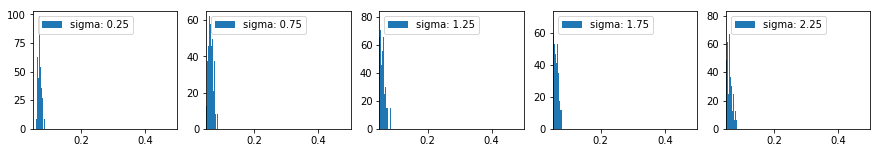

In [9]:
import matplotlib.pyplot as plt

results_list = results.get()
fig = plt.figure(figsize=(15, 10))
N_ROW = 4
for idx, (sigma, result) in enumerate(results_list[:5]):
    ax = fig.add_subplot(N_ROW, len(results_list)//N_ROW, idx+1)
    tmp = ax.hist(result,  normed=True, bins=40, label="sigma: {}".format(sigma))
    ax.set_xlim(uni_prior_down[0], uni_prior_up[0])
    ax.legend(loc='upper left')

In [12]:
fig.savefig("/Home/varioper/hajian/UQ/results/sigma.png")

# Testing